In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-15, -15, -30]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10, 170, 190]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [5]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 23.29 23.43 23.57 23.71 ... 1.506 1.446 1.387 1.33

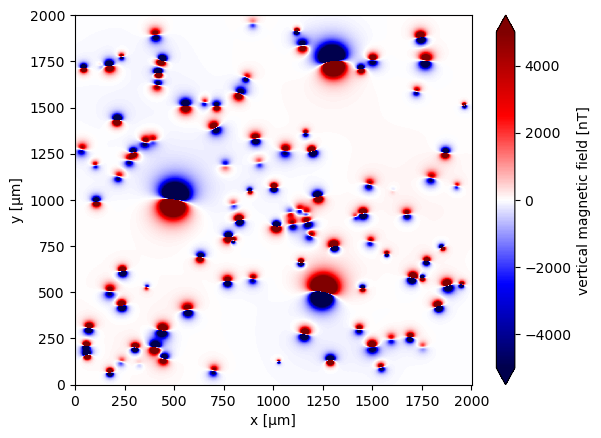

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [7]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

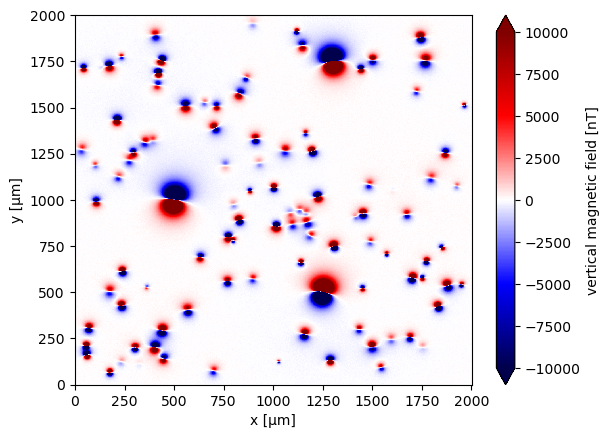

In [8]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Polynomial fitting to suppress high frequency noise
2. Upward continue the data to suppress high frequency noise
3. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
4. Contrast stretch the TGA to highlight weaker sources
5. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Polynomial fitting to suppress low frequency noise

In [9]:
trend = vd.Trend(degree=3).fit((coordinates), data.bz.values)
low_frequency_noise = trend.predict(coordinates).reshape(data.bz.shape)

data = data.assign(low_freq=(['y','x'],low_frequency_noise))
data.low_freq.attrs = {"long_name": "low-frequency noise", "units": "nT"}

residual = data.bz.values - data.low_freq.values
data = data.assign(residual=(['y','x'],residual))
data.residual.attrs = {"long_name": "residual anomaly", "units": "nT"}

data

<xarray.Dataset>
Dimensions:   (y: 1001, x: 1001)
Coordinates:
  * x         (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y         (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z         (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz        (y, x) float64 38.53 -28.57 61.09 70.74 ... -65.8 -15.49 -28.8
    low_freq  (y, x) float64 297.1 295.4 293.7 292.0 ... -220.3 -221.0 -221.6
    residual  (y, x) float64 -258.5 -323.9 -232.6 -221.3 ... 154.5 205.5 192.8

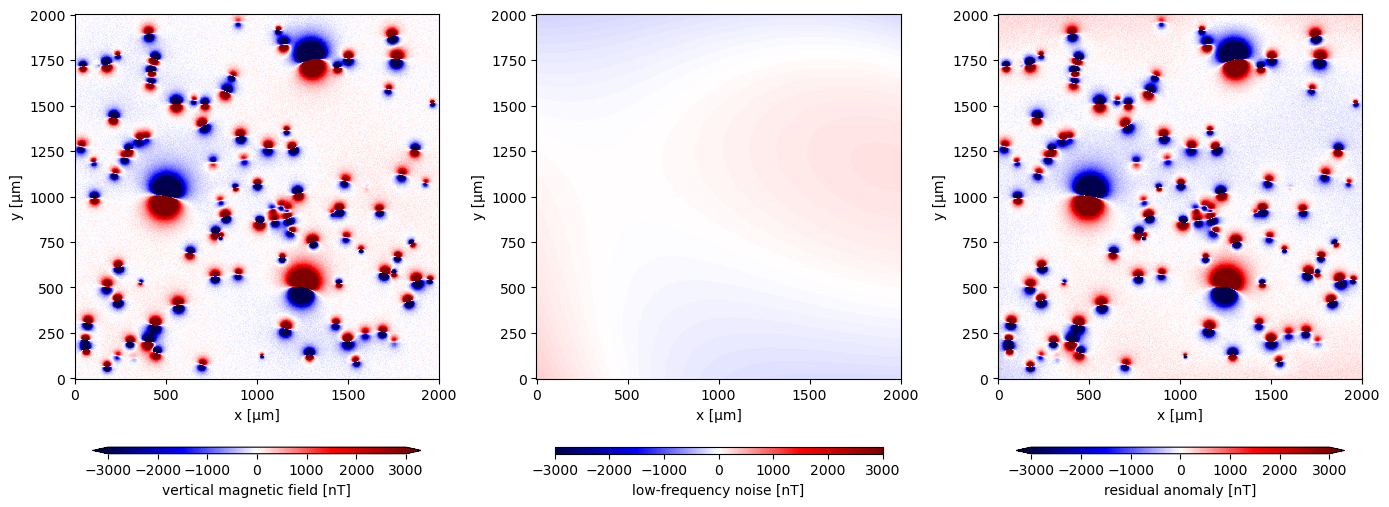

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 14))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.9)
for field, ax in zip(["bz", "low_freq", "residual"], axes.ravel()):
    vmax, vmin = 3000, -3000
    if field != "low_freq":
        vmax=+3000
        vmin=-3000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

## 2. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [11]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 3.699 5.177 6.767 7.257 ... -0.3299 -0.3933 -0.01999

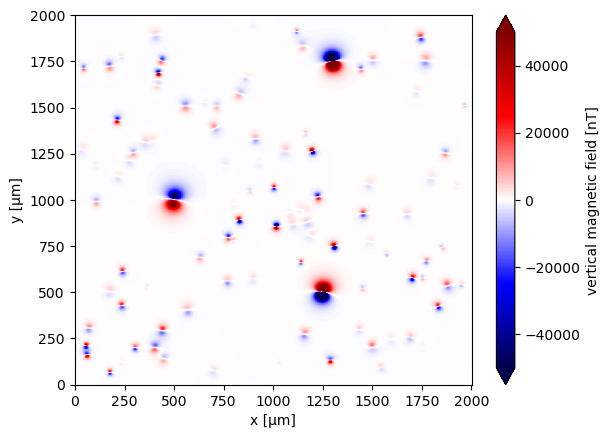

In [12]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 3. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [13]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 3.699 5.177 6.767 7.257 ... -0.3299 -0.3933 -0.01999
    tga      (y, x) float64 1.514 1.423 1.934 1.808 ... 1.329 1.596 1.468 1.409
    x_deriv  (y, x) float64 0.739 0.7669 0.52 0.06259 ... -0.2063 0.07748 0.1867
    y_deriv  (y, x) float64 1.321 1.026 0.9394 1.27 ... 1.057 1.13 1.208 1.162
    z_deriv  (y, x) float64 -0.03813 -0.6186 -1.608 ... 1.108 0.8295 0.7746

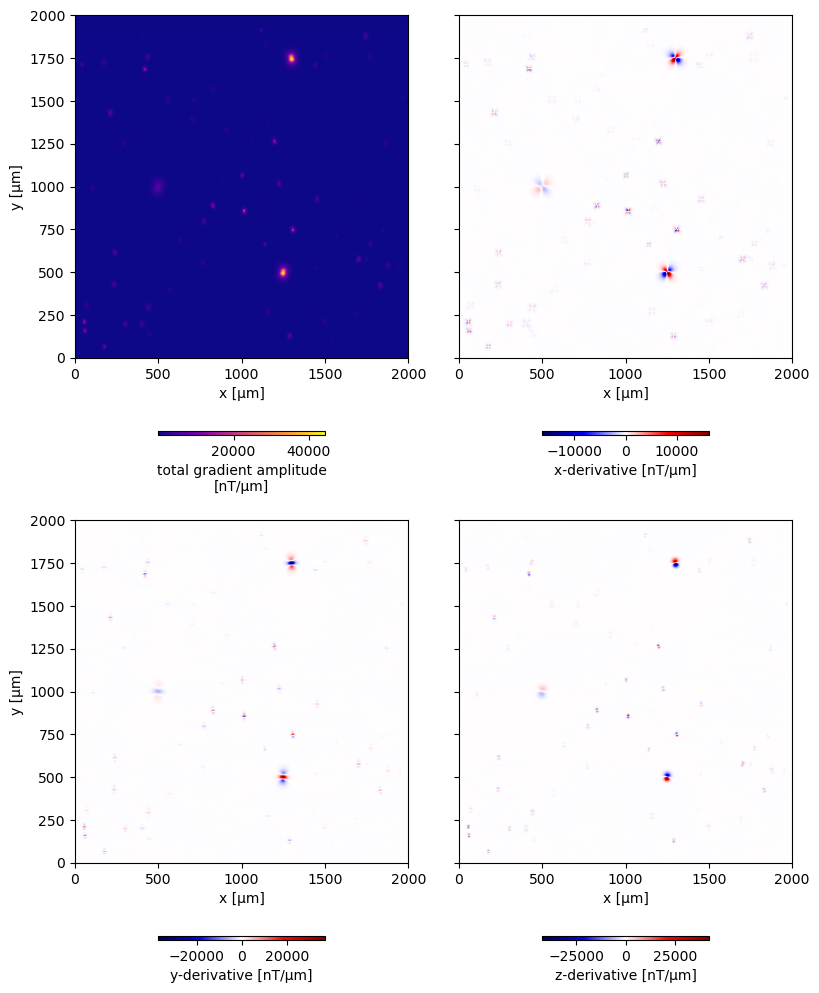

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [15]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

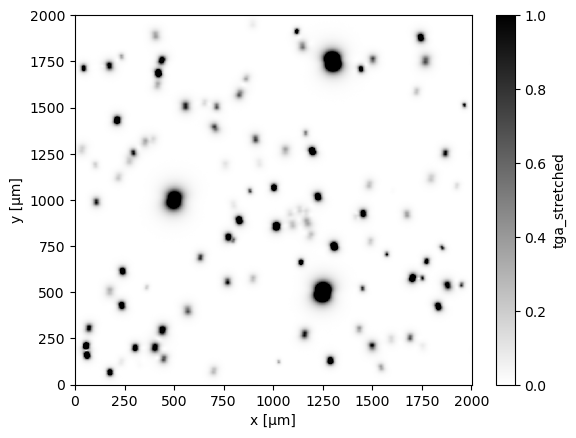

In [16]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 5. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [17]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.3,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [18]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  99


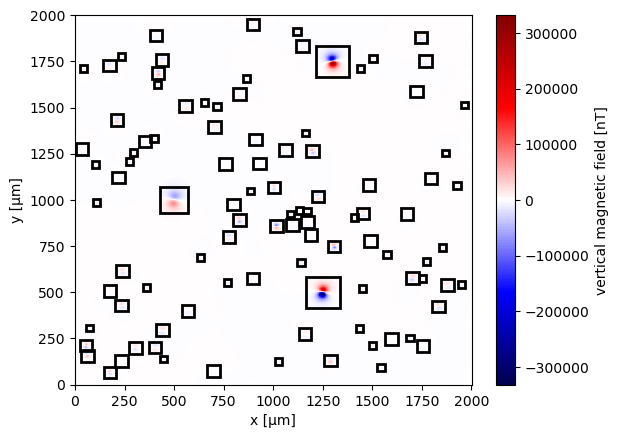

In [19]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [20]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.999939838574243 and SNR: 42.225799717099825
R²: 0.999940244813256 and SNR: 42.25393189605472
R²: 0.9991310352215711 and SNR: 30.62797350946901
R²: 0.9991316540674033 and SNR: 30.754029495606055
R²: 0.9991343165850678 and SNR: 30.73005765464363
R²: 0.9993871609582028 and SNR: 32.13584955206821
R²: 0.9999919563712123 and SNR: 50.947537346131824
R²: 0.9996536298770703 and SNR: 34.62150460561726
R²: 0.999694738912736 and SNR: 35.20472425659834
R²: 0.9995170261771454 and SNR: 33.38789517995777
R²: 0.9996511903224217 and SNR: 34.57433496343514
R²: 0.9983446636472773 and SNR: 27.81227146297161
R²: 0.9991123032541953 and SNR: 30.536180219151014
R²: 0.9995622279424626 and SNR: 33.66270547764466
R²: 0.9998152143859432 and SNR: 37.37407558452538
R²: 0.9984787398986135 and SNR: 28.323637429666768
R²: 0.9991352863949808 and SNR: 30.635863008367924
R²: 0.9996610350255147 and SNR: 34.70210510437593
R²: 0.9989100453778099 and SNR: 29.656037199987168
R²: 0.9983835023688816 and SNR: 27.91641481152

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [21]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 1.92495884e-01,  1.92564356e-01,  3.85550780e-01,  3.90557342e-01,
        3.90196314e-01,  3.62624106e-01,  1.16218879e-01,  3.06123968e-01,
        2.66783813e-01,  3.27059587e-01,  3.24409378e-01,  5.13854448e-01,
        3.51170521e-01,  3.36253719e-01,  3.24875323e-01,  2.96438174e-01,
        3.88888729e-01,  3.27997756e-01,  4.67115539e-01,  2.10889397e-01,
       -8.71789658e-03,  4.25377630e-01,  3.63546001e-01,  5.13018965e-01,
        3.51791385e-01,  3.35094870e-01,  6.85478482e-01,  1.04280705e-01,
        1.99271706e-01,  1.01884342e-01,  1.83604288e-01,  2.10663484e-01,
        3.18132090e-01,  3.26228775e-01,  2.41956422e-01,  4.23461754e-01,
        2.91978031e-01, -7.79830286e-01,  3.28849037e-01,  3.57393581e-01,
        4.01445245e-01,  2.67739464e-01,  3.94297670e-01,  2.16193135e-01,
        1.24836295e+00,  3.86971590e-01,  2.69270064e-01,  4.33431492e-04,
        3.48873734e-01,  2.23148526e-01,  1.31776463e-01,  3.32739867e-01,
        3.35163667e-01,  

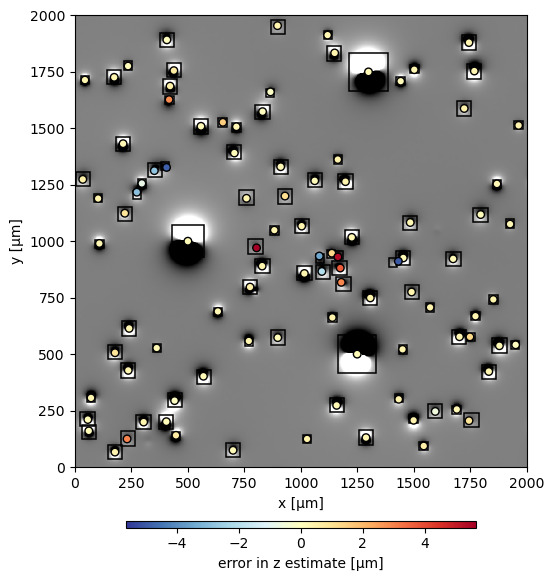

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [23]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    # print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    # print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    # print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    # print(f"R²   : {r2:.5f} ")
    # print(f"SNR  : {SNR:.5f} ")
    # print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    # print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    # print()

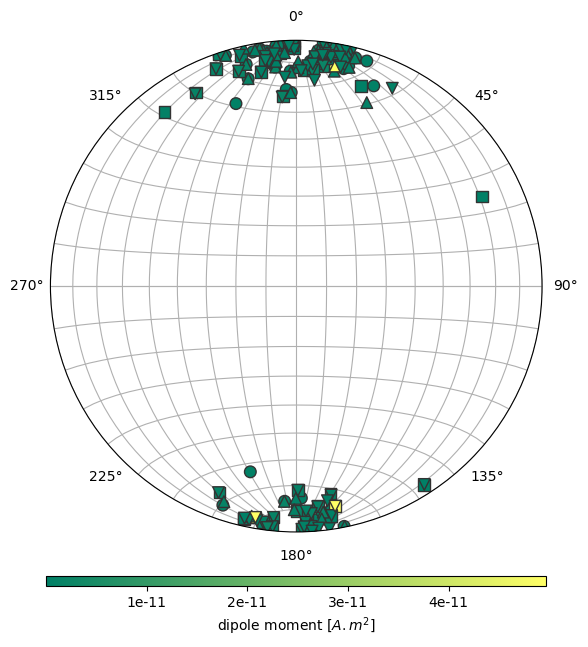

In [24]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

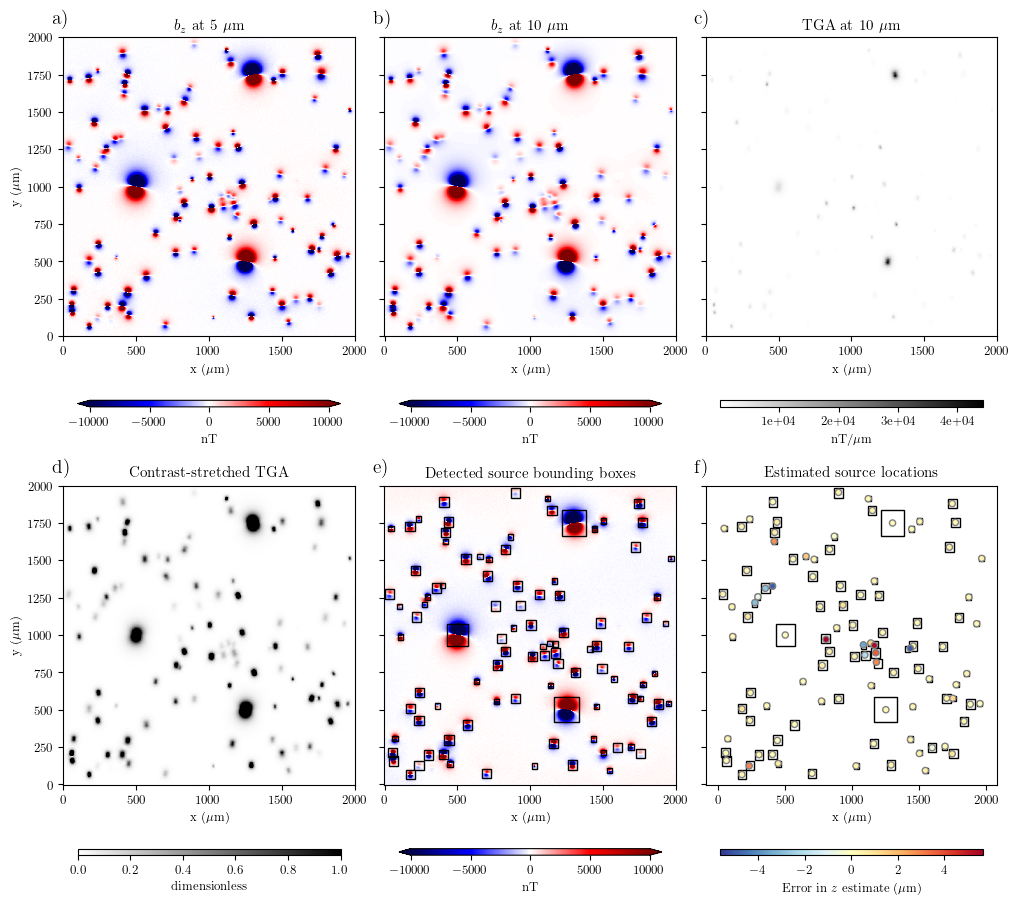

In [26]:
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.residual.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   

    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="Error in $z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
    fig.savefig(fig_dir / "complex-synthetic-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

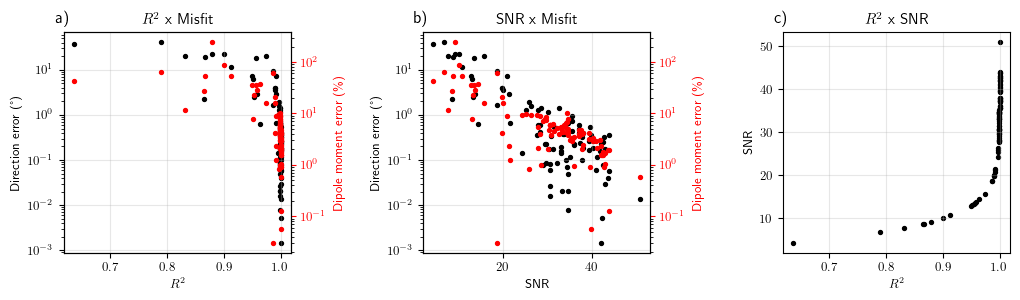

In [27]:
with plt.rc_context(mpl_rc):
    size=8
    fig, axes = plt.subplots(1,3, figsize=(10, 2.8))    

    axes = axes.ravel()
    ax = axes[0]
    ax.scatter(calculated_r2, direction_misfit, color='k', s=size)
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('$R^2$')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_r2, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[1]
    ax.scatter(calculated_SNR, direction_misfit, color='k', s=size, label='direction (°)')
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('SNR')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_SNR, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_xlabel('SNR')
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[2]
    ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
    ax.set_xlabel('$R^2$')
    ax.set_ylabel('SNR')

    titles = [r'$R^2$ x Misfit', r'SNR x Misfit', r'$R^2$ x SNR']
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_aspect("auto")
        ax.grid(alpha=0.3, which='major')
        ax.set_title(title)




    plt.tight_layout(pad=0, h_pad=0, w_pad=2)
    
    fig.savefig(fig_dir / "complex-synthetic-fitting-test.png", dpi=300, facecolor='w', bbox_inches='tight')

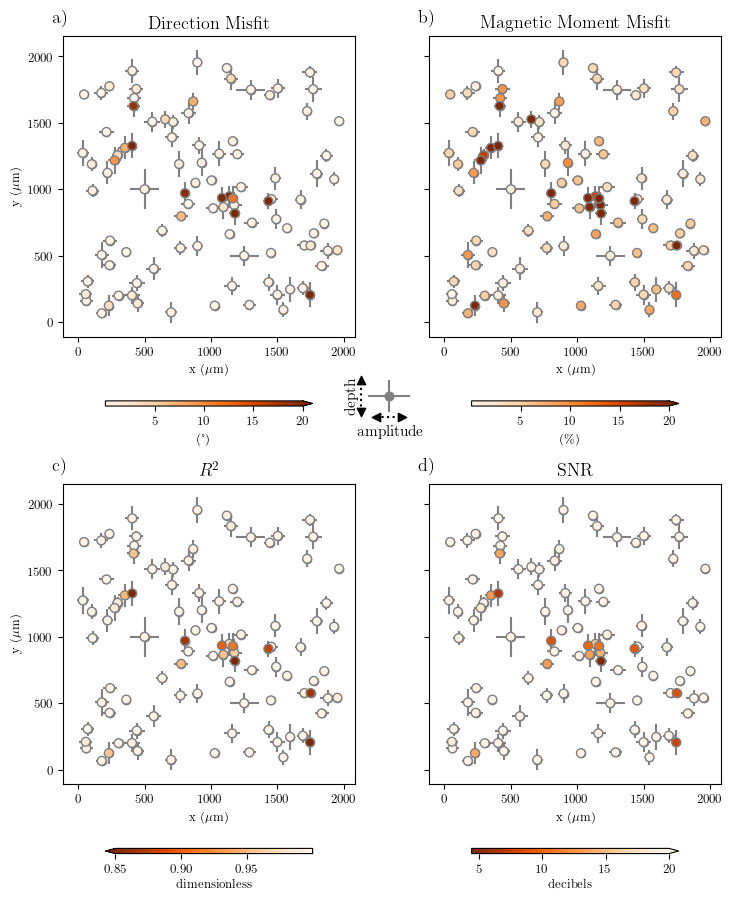

In [28]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(8, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"$R^2$", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    scale = 0.85
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"SNR", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    
    scale = 20
    tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
    fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
    left, bottom, width, height = [0.45, 0.52, 0.09, 0.09]
    ax5 = fig.add_axes([left, bottom, width, height])
    ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
                 fmt='o', zorder=0, color='gray')
    ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
    ax5.set_ylim(-1.0, 1.5)
    ax5.set_xlim(-0.6, 1.1)

    ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
    ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
    ax5.scatter(-0.15, -0.0, marker='v', color='k')
    ax5.scatter(-0.15, 1.0, marker='^', color='k')

    ax5.scatter(0.2,-0.15, marker='<', color='k')
    ax5.scatter(0.8,-0.15, marker='>', color='k')

    ax5.text(-0.25, -0.7, 'amplitude', color='k', fontsize=11)
    ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

    ax5.set_title('', loc='left')
    # Eliminate upper and right axes
    ax5.spines['right'].set_color('none')
    ax5.spines['top'].set_color('none')
    ax5.spines['bottom'].set_color('none')
    ax5.spines['left'].set_color('none')
    ax5.xaxis.set_ticks([])
    ax5.yaxis.set_ticks([])
    
    fig.savefig(fig_dir / "complex-synthetic-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()


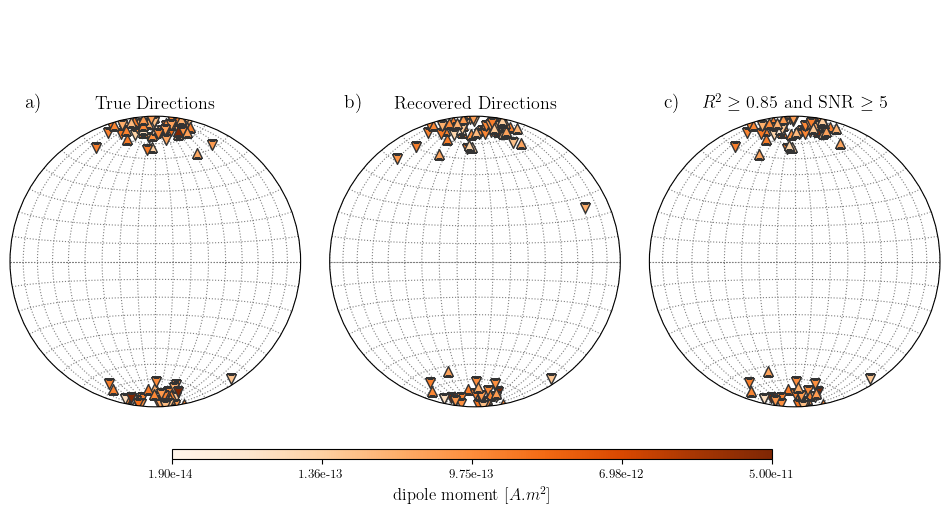

In [29]:
with plt.rc_context(mpl_rc):
    fig, axes = mplstereonet.subplots(1, 3, figsize=(12, 5))

    estimated = mg.vector_to_angles(estimated_dipole_moments)
    true = mg.vector_to_angles(dipole_moments)
    scatter_args = dict(
        vmin=np.min([np.log10(np.min(estimated[2])), np.log10(np.min(true[2]))]),
        vmax=np.max([np.log10(np.max(estimated[2])), np.log10(np.max(true[2]))]),
        cmap="Oranges",
        edgecolors="#333333",
        linewidths=1,
        s=50,
        zorder=2,
    )

    
    ticks=np.linspace( np.min([np.log10(np.min(estimated[2])), np.log10(np.min(true[2]))]),
                       np.max([np.log10(np.max(estimated[2])), np.log10(np.max(true[2]))]), 5)
    
    ax = axes[0]
    for i in range(len(dipole_moments)):
        true = mg.vector_to_angles(dipole_moments[i])
        pos_inc = true[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
            c=np.log10(true[2][pos_inc]),
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
            c=np.log10(true[2][~pos_inc]),
            marker="v",
            **scatter_args,
        )

    ax = axes[1]       
    for i in range(len(estimated_dipole_moments)):
        estimated = mg.vector_to_angles(estimated_dipole_moments[i])
        pos_inc = estimated[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
            c=np.log10(estimated[2][pos_inc]),
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
            c=np.log10(estimated[2][~pos_inc]),
            marker="v",
            **scatter_args,
        )

    ax = axes[2]
    count_r2 = 0         
    for i in range(len(calculated_r2)):
        if calculated_r2[i] >= 0.85 and calculated_SNR[i] >= 5:
#         if calculated_SNR[i] >= 20:
            count_r2 += 1
            estimated = mg.vector_to_angles(estimated_dipole_moments[i])
            pos_inc = estimated[0] > 0
            tmp = ax.scatter(
                *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
                c=np.log10(estimated[2][pos_inc]),
                marker="^",
                **scatter_args,
            )
            tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c=np.log10(estimated[2][~pos_inc]),
                marker="v",
                **scatter_args,
            )

    tick_labels = []
    for i in (ticks):
        tick_labels.append("{:.2e}".format(10**i))


    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.26, 0.10, 0.5, 0.02]), 
        orientation="horizontal", 
        format="%.2e",
        ticks = ticks)
    clb.set_label(label="dipole moment [$A.m^2$]", fontsize=12)
    clb.set_ticklabels(tick_labels)

#     fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.3, 0.1, 0.4, 0.02]), 
#         orientation="horizontal",
#         format="%.0e"
#     ).set_label(label="dipole moment [$A.m^2$]", size=12)

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_azimuth_ticks([])
        ax.grid(linestyle=':', color='gray')
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.1)
    # plt.tight_layout(pad=0, h_pad=0, w_pad=0.7)
    
#     fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()


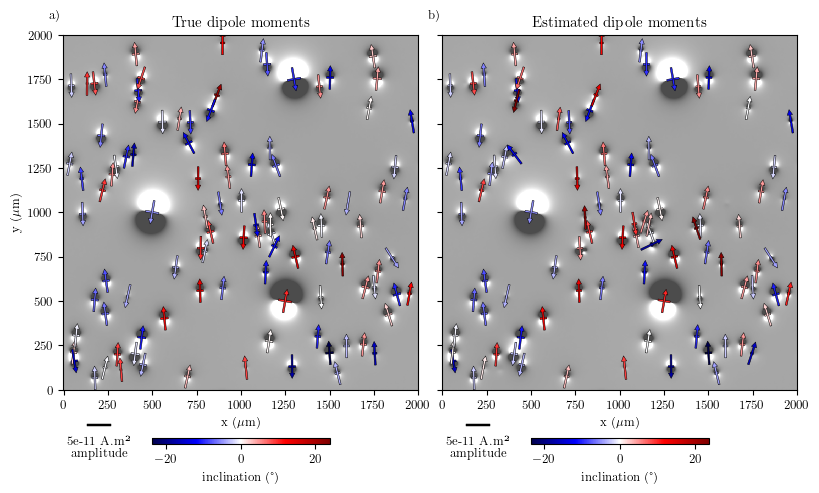

In [30]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    
    for ax in axes:
        scale = 2000
        data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
        ax.set_aspect("equal")
        
    cbar_kwargs = dict(orientation="horizontal", aspect=30, pad=0.1, shrink=0.5, label="inclination (°)")
    
    ax = axes[0]
    inc, amp = mg.plot_dipole_moment(dipole_coordinates, dipole_moments, ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_title("True dipole moments")
    
    ax = axes[1]
    inc, amp = mg.plot_dipole_moment(positions, estimated_dipole_moments, ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_title("Estimated dipole moments")
    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    fig.savefig(fig_dir / "complex-synthetic-dipole-moments.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

96


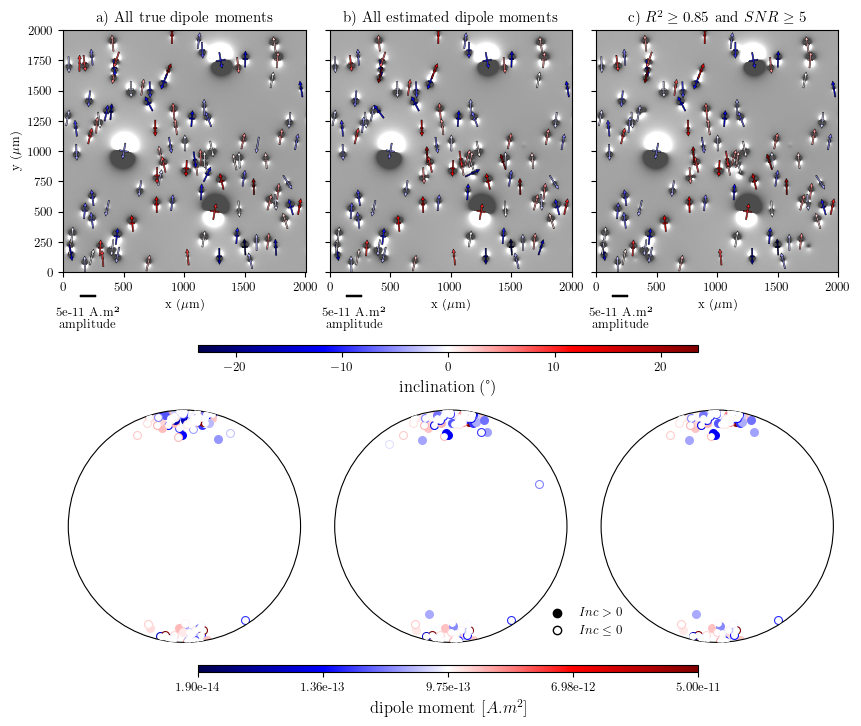

In [31]:
import micromag as mg
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 3, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1.25]}, sharey=True)
    plt.rcParams["figure.autolayout"] = True
    

    cbar_kwargs = dict(orientation="horizontal", aspect=30, pad=0.1, shrink=0.5, label="inclination (°)")
    
    good = (np.array(calculated_r2) >= 0.85) & (np.array(calculated_SNR) >= 5)
    print(np.sum(good))

################################################################################    
    ax = plt.subplot(231)
    
    scale = 1000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    ax.set_aspect("equal")
    
    inc, amp = mg.plot_dipole_moment(dipole_coordinates, dipole_moments, ax=ax, add_colorbar=False)
#     plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_title("a) All true dipole moments")    

################################################################################
    ax = plt.subplot(232)
    
    scale = 1000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    ax.set_aspect("equal")
    
    inc, amp = mg.plot_dipole_moment(positions, estimated_dipole_moments, ax=ax, add_colorbar=False)
#     plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_title("b) All estimated dipole moments")

################################################################################
    ax = plt.subplot(233)
    
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    ax.set_aspect("equal")
    
    inc, amp = mg.plot_dipole_moment(positions.T[good].T, np.array(estimated_dipole_moments)[good], ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs,
                cax=fig.add_axes([0.26, 0.4, 0.5, 0.0075])).set_label(label='inclination (°)', fontsize=12)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_title("c)~$R^2 \ge 0.85$ and $SNR \ge 5$")  
    
################################################################################
    ax = plt.subplot(234, projection='stereonet', facecolor='white')
#     ax.grid(color='black', linestyle=':')
    true = mg.vector_to_angles(dipole_moments)
    estimated = mg.vector_to_angles(estimated_dipole_moments)
    
    # legend ticks
    vmin=np.log10(np.min([np.min(true[2]), np.min(estimated[2])])),
    vmax=np.log10(np.max([np.max(true[2]), np.max(estimated[2])])),
    
    ticks=np.linspace(vmin, vmax, 5)

    scatter_args = dict(
        vmin=np.log10(np.min([np.min(true[2]), np.min(estimated[2])])),
        vmax=np.log10(np.max([np.max(true[2]), np.max(estimated[2])])),
        cmap= "seismic",
        linewidths=1,
        s=30,
        zorder=2,
    )

    ticks=np.linspace( np.log10(np.min(true[2])),
                       np.log10(np.max(true[2])), 5)
       
    for i in range(len(dipole_moments)):
        true = mg.vector_to_angles(dipole_moments[i])
        pos_inc = true[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
            c=np.log10(true[2][pos_inc]),
            marker="o",
            **scatter_args,
        )
        tmp = ax.scatter(
                *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
                c='w',
                marker="o",
                linewidths=1,
                s=15,
                zorder=3,
            )
        tmp = ax.scatter(
            *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
            c=np.log10(true[2][~pos_inc]),
            marker="o",
            **scatter_args,
        )    
    
################################################################################
    ax = plt.subplot(235, projection='stereonet', facecolor='white')
#     ax.grid(color='black', linestyle=':')
#     estimated = mg.vector_to_angles(estimated_dipole_moments)

#     scatter_args = dict(
#         vmin=np.log10(np.min(estimated[2])),
#         vmax=np.log10(np.max(estimated[2])),
#         cmap= "seismic",
#         linewidths=1,
#         s=30,
#         zorder=2,
#     )

       
    for i in range(len(estimated_dipole_moments)):
        estimated = mg.vector_to_angles(estimated_dipole_moments[i])
        pos_inc = estimated[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
            c=np.log10(estimated[2][pos_inc]),
            marker="o",
            **scatter_args,
        )
        tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c='w',
                marker="o",
                linewidths=1,
                s=15,
                zorder=3,
            )
        tmp = ax.scatter(
            *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
            c=np.log10(estimated[2][~pos_inc]),
            marker="o",
            **scatter_args,
        )

################################################################################
    ax = plt.subplot(236, projection='stereonet', facecolor='white')
#     ax.grid(color='black', linestyle=':')
    count_r2 = 0         
    
    for i in range(len(calculated_r2)):
        if calculated_r2[i] >= 0.85 and calculated_SNR[i] >= 5:
            count_r2 += 1
            estimated = mg.vector_to_angles(estimated_dipole_moments[i])
            pos_inc = estimated[0] > 0
            tmp = ax.scatter(
                *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
                c=np.log10(estimated[2][pos_inc]),
                marker="o",
                **scatter_args,
            )
            tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c='w',
                marker="o",
                linewidths=1,
                s=15,
                zorder=3,
            )
            tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c=np.log10(estimated[2][~pos_inc]),
                marker="o",
                **scatter_args,
            )

    plt.scatter([],[], marker='o', color='k', edgecolors='k', label=r'$Inc > 0° $')
    plt.scatter([],[], marker='o', color='w', edgecolors='k', label=r'$Inc \leq 0° $')

    legend = plt.legend(bbox_to_anchor=(0.14, 0.2), frameon=1, framealpha=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    frame.set_edgecolor('w')


    tick_labels = []
    for i in (ticks):
        tick_labels.append("{:.2e}".format(10**i))


    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.26, 0.08, 0.5, 0.0075]), 
        orientation="horizontal", 
        format="%.2e",
        ticks = ticks,
        aspect=50,
        pad=0.1)
    clb.set_label(label="dipole moment [$A.m^2$]", fontsize=12)
    clb.set_ticklabels(tick_labels)



#     titles = ('True Directions','Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

#     for ax, letter, title in zip(axes.ravel(), "a b c d e f".split(), titles):
#         ax.text(0.00, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
    fig.subplots_adjust(wspace=0.1, hspace=-0.05)

    
    fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

### Show the observed and predicted data

In [32]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions, estimated_dipole_moments)
residuo = data.bz.values - predicted_data

In [33]:
data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}



In [34]:
data_up

<xarray.Dataset>
Dimensions:         (y: 1001, x: 1001)
Coordinates:
  * y               (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * x               (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z               (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz              (y, x) float64 3.699 5.177 6.767 ... -0.3933 -0.01999
    tga             (y, x) float64 1.514 1.423 1.934 1.808 ... 1.596 1.468 1.409
    x_deriv         (y, x) float64 0.739 0.7669 0.52 ... -0.2063 0.07748 0.1867
    y_deriv         (y, x) float64 1.321 1.026 0.9394 1.27 ... 1.13 1.208 1.162
    z_deriv         (y, x) float64 -0.03813 -0.6186 -1.608 ... 0.8295 0.7746
    tga_stretched   (y, x) float64 0.0006501 0.0005952 ... 0.0006223 0.000587
    predicted_data  (y, x) float64 -4.541 -4.578 -4.616 ... 0.2865 0.2533 0.2212
    error           (y, x) float64 8.24 9.756 11.38 ... -0.6165 -0.6467 -0.2412

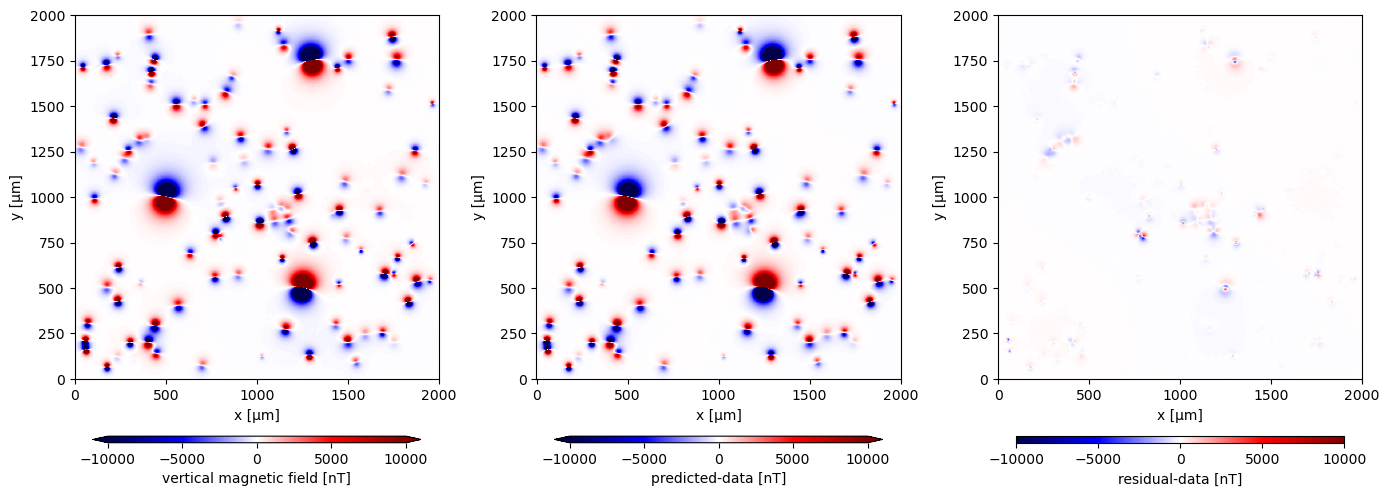

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### Show each window results
We displayed only the first 5 windows

0.9999366599965368 42.19382092861054
0.999939838574243 42.225799717099825


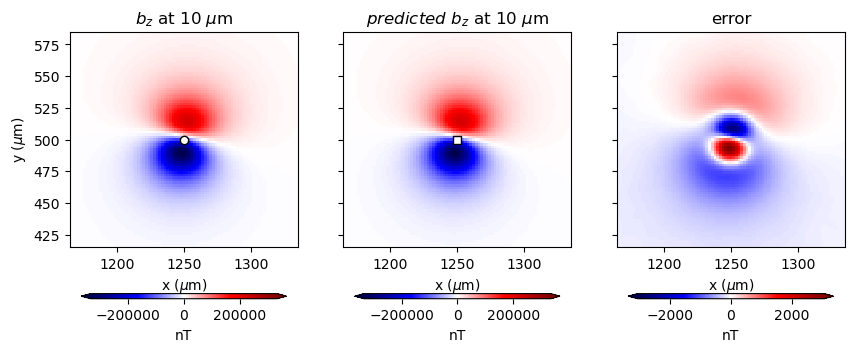

0.9999363277676553 42.25713695686716
0.999940244813256 42.25393189605472


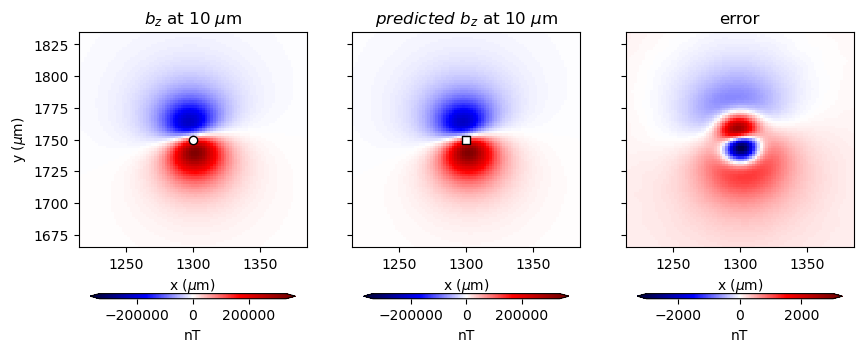

0.9991169356474582 30.58168380637547
0.9991310352215711 30.62797350946901


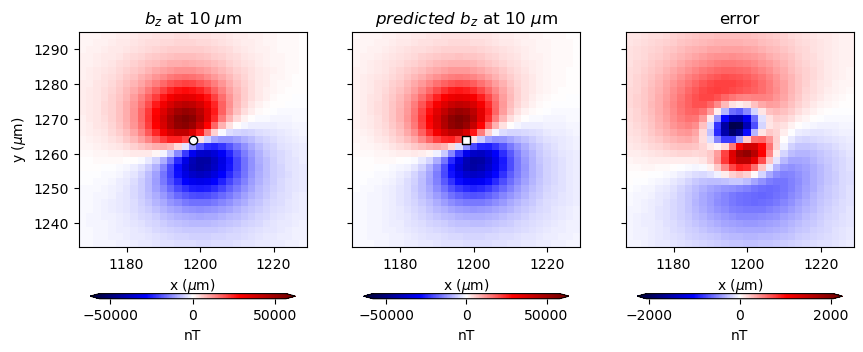

0.9990732039186863 30.506328712550996
0.9991316540674033 30.754029495606055


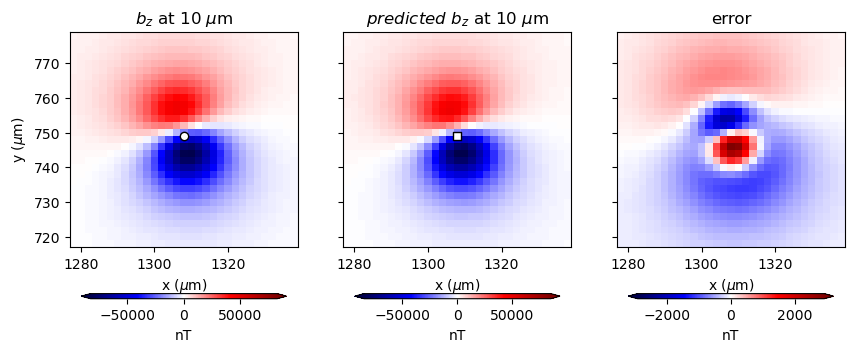

0.9989673250410244 30.25686913559966
0.9991343165850678 30.73005765464363


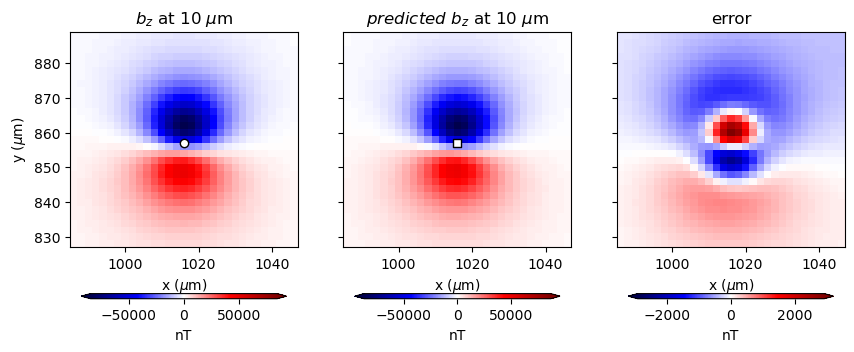

In [36]:
for window, r2, SNR in zip(windows_filtered[0:5], calculated_r2[0:5], calculated_SNR[0:5]):
    local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(positions[0], positions[1], color='w', marker='s', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    print(r2_window, SNR_window)
    print(r2, SNR)
    

    plt.show()